# FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

>Part 1: Data Preparation and Exploration

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
df =  pd.read_csv('exchange_rate.csv', parse_dates=True, index_col='date')
df.head()

,Ex_rate
date,
01-01-1990 00:00,0.7855
02-01-1990 00:00,0.7818
03-01-1990 00:00,0.7867
04-01-1990 00:00,0.7860
05-01-1990 00:00,0.7849


In [14]:
df.shape

(7588, 1)

In [15]:
df.columns

Index(['Ex_rate'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 376.6+ KB


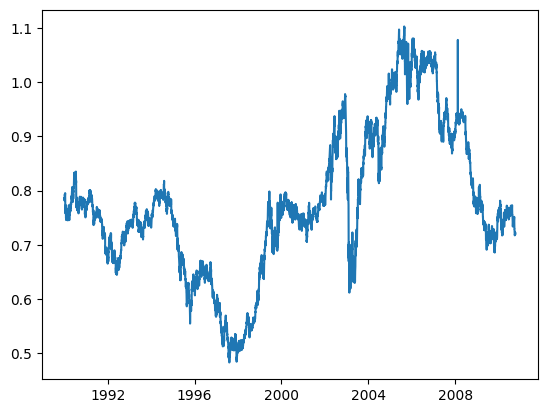

In [23]:
#	Initial Exploration
from statsmodels.tsa.seasonal import seasonal_decompose

plt.plot(df)

In [27]:
df.index = pd.to_datetime(df.index, format='%d-%m-%Y %H:%M', dayfirst=True)
df.index.freq = 'D'
df.head()


,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [28]:
model = seasonal_decompose(df['Ex_rate'],model='multiplicative')

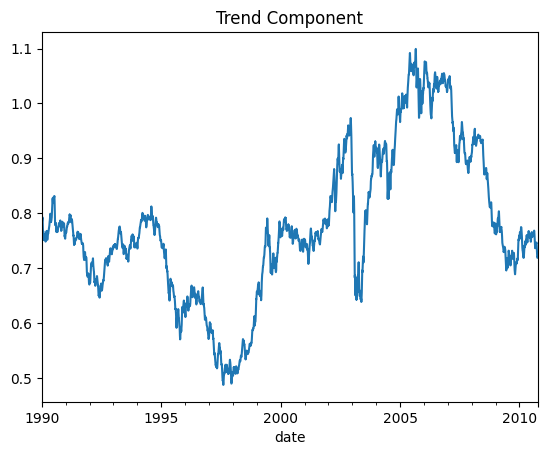

In [29]:
model.trend.plot()
plt.title('Trend Component')
plt.show()

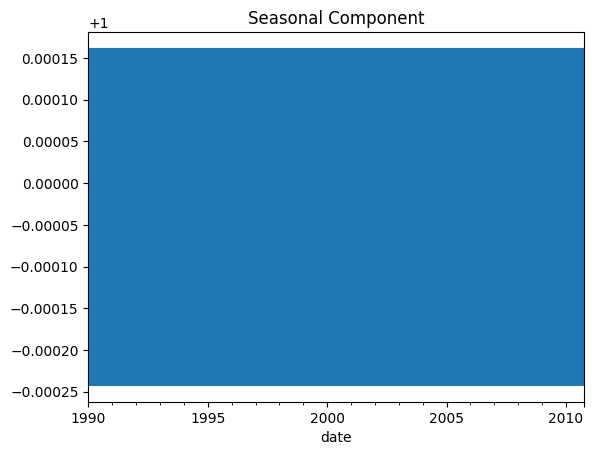

In [30]:
model.seasonal.plot()
plt.title('Seasonal Component')
plt.show()

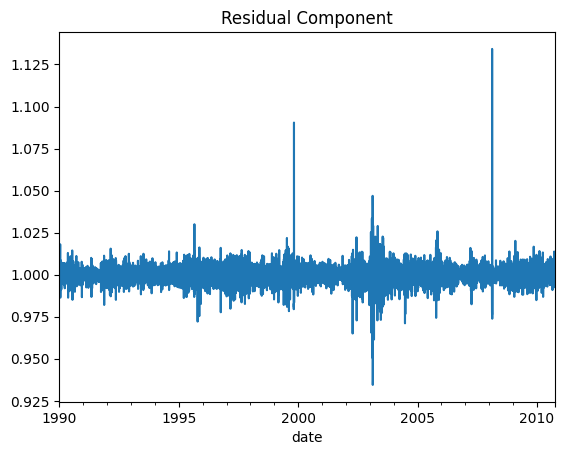

In [33]:
model.resid.plot()
plt.title('Residual Component')
plt.show()

1. **Trend component** →
   The line plot clearly shows a smooth long-term rise and fall pattern.

2. **Seasonal component** →
   The blue block looks nearly flat around zero, meaning the dataset has **very weak or no seasonality**.

3. **Residual component** →
   The residuals fluctuate randomly around 1.0 with some spikes, which means your model successfully isolated random noise.

In [34]:
# Check missing values
df.isnull().sum()


,0
Ex_rate,0


In [35]:
# Detect outliers using the 3-sigma rule
mean = df['Ex_rate'].mean()
std = df['Ex_rate'].std()

upper_limit = mean + 3*std
lower_limit = mean - 3*std

outliers = df[(df['Ex_rate'] > upper_limit) | (df['Ex_rate'] < lower_limit)]
print(f"Number of outliers: {len(outliers)}")


Number of outliers: 0


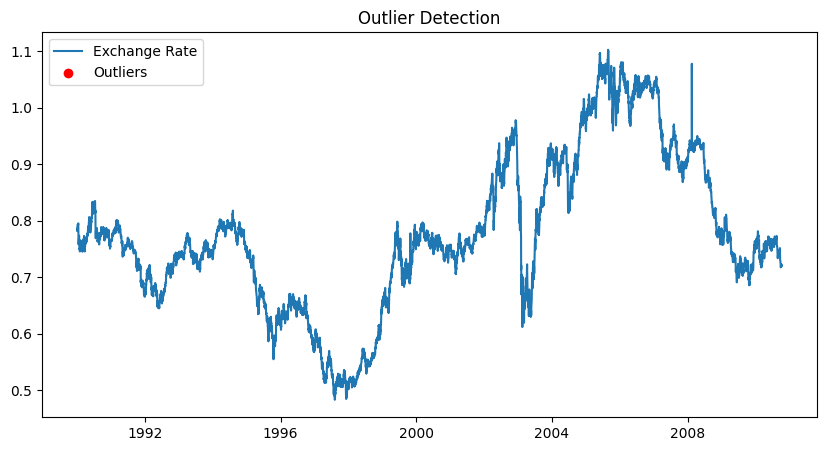

In [36]:
# Visualize
plt.figure(figsize=(10,5))
plt.plot(df['Ex_rate'], label='Exchange Rate')
plt.scatter(outliers.index, outliers['Ex_rate'], color='red', label='Outliers')
plt.title('Outlier Detection')
plt.legend()
plt.show()

>Part 2: Model Building - ARIMA

In [38]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [41]:
# Check Stationarity
result = adfuller(df['Ex_rate'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print(" The series is stationary — no differencing needed.")
    d = 0
else:
    print("The series is NOT stationary — differencing will be applied.")
    d = 1

# If not stationary, difference the data
if d == 1:
    df_diff = df['Ex_rate'].diff().dropna()
else:
    df_diff = df['Ex_rate']

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
The series is NOT stationary — differencing will be applied.


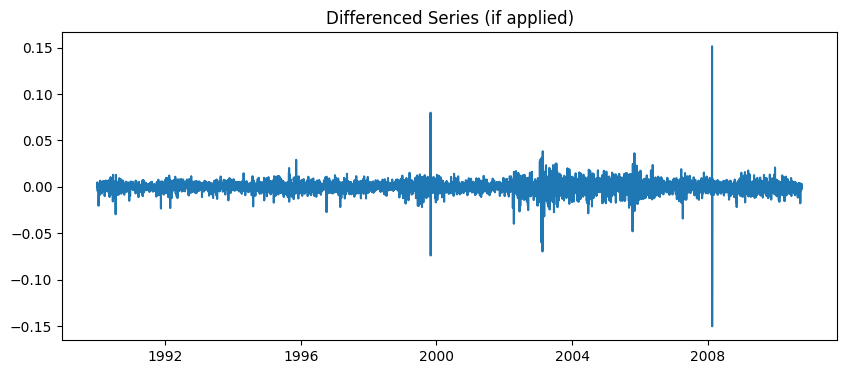

In [40]:
# Plot differenced data
plt.figure(figsize=(10,4))
plt.plot(df_diff)
plt.title('Differenced Series (if applied)')
plt.show()

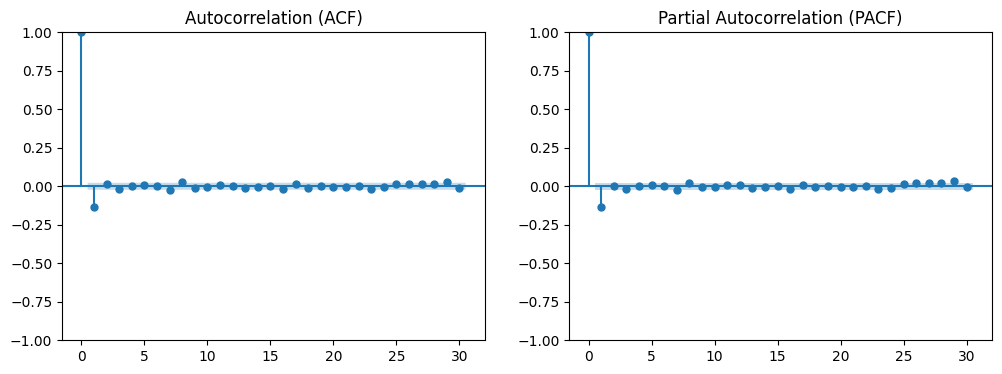

In [43]:
# ACF and PACF Plots (to estimate p, q)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(df_diff, ax=axes[0], lags=30)
plot_pacf(df_diff, ax=axes[1], lags=30)
axes[0].set_title('Autocorrelation (ACF)')
axes[1].set_title('Partial Autocorrelation (PACF)')
plt.show()

In [44]:
# Fit the ARIMA Model
model = ARIMA(df['Ex_rate'], order=(1, d, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sat, 01 Nov 2025   AIC                         -56102.322
Time:                        07:01:44   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

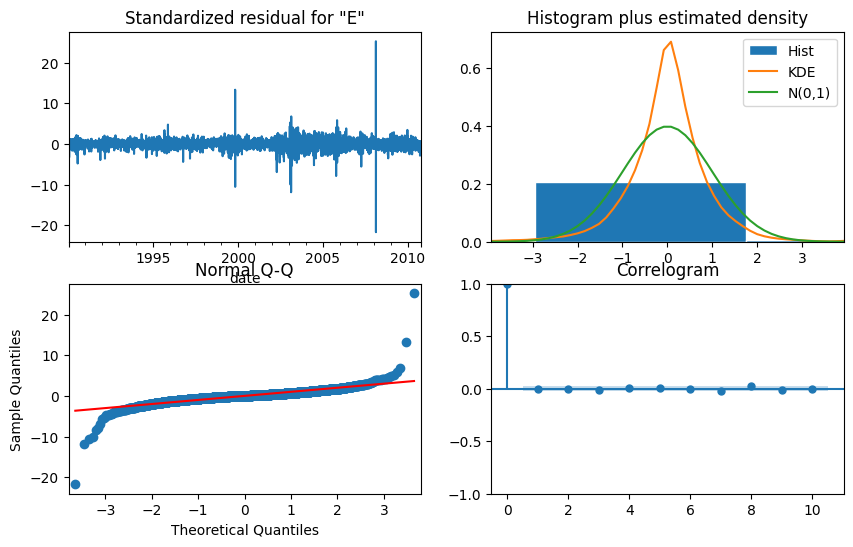

In [45]:
# Diagnostics (Residual Analysis)
model_fit.plot_diagnostics(figsize=(10,6))
plt.show()


In [46]:
# Forecasting
forecast_steps = 30  # forecast next 30 days.
forecast = model_fit.forecast(steps=forecast_steps)

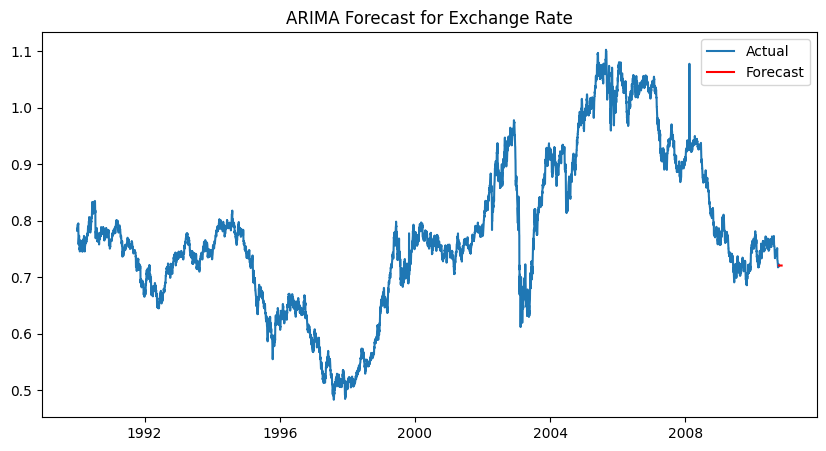

In [47]:
# Visualize forecast vs actual
plt.figure(figsize=(10,5))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:],
         forecast, color='red', label='Forecast')
plt.title('ARIMA Forecast for Exchange Rate')
plt.legend()
plt.show()

>Part 3: Model Building - Exponential Smoothing

In [48]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

holt_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None).fit()

print("Holt's Model Parameters:")
print(holt_model.params)


Holt's Model Parameters:
{'smoothing_level': np.float64(0.8698402860748511), 'smoothing_trend': np.float64(0.0), 'smoothing_seasonal': np.float64(nan), 'damping_trend': nan, 'initial_level': np.float64(0.7851093972242965), 'initial_trend': np.float64(-8.473596416712384e-06), 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [49]:
# Forecasting
forecast_steps = 30
holt_forecast = holt_model.forecast(steps=forecast_steps)

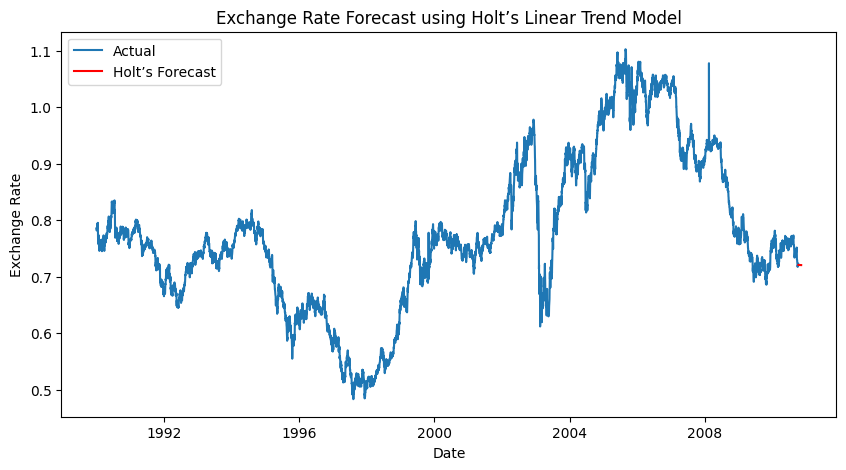

In [50]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:],
         holt_forecast, label='Holt’s Forecast', color='red')
plt.title("Exchange Rate Forecast using Holt’s Linear Trend Model")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Align actuals and forecasts
mae = mean_absolute_error(df['Ex_rate'][-forecast_steps:], holt_forecast[:forecast_steps])
rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-forecast_steps:], holt_forecast[:forecast_steps]))

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")


MAE: 0.012755
RMSE: 0.017005


>Part 4: Evaluation and Comparison

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Split data (80% training, 20% testing)
train_size = int(len(df) * 0.8)
train_data, test_data = df[0:train_size], df[train_size:]

actual = test_data['Ex_rate']

In [58]:
# Ensure equal lengths
min_len = min(len(actual), len(forecast), len(holt_forecast))
actual_truncated = actual[:min_len].copy()
arima_forecast_truncated = pd.Series(forecast[:min_len]).copy()
holt_forecast_truncated = pd.Series(holt_forecast[:min_len]).copy()

# Clean data: remove NaN, inf, and zero values
comparison_df = pd.DataFrame({
    'actual': actual_truncated.values,
    'arima': arima_forecast_truncated.values,
    'holt': holt_forecast_truncated.values
})

# Drop rows where actual is NaN, inf, or 0
comparison_df = comparison_df.replace([np.inf, -np.inf], np.nan).dropna()
comparison_df = comparison_df[comparison_df['actual'] != 0]

# Extract cleaned series
actual_clean = comparison_df['actual']
arima_clean = comparison_df['arima']
holt_clean = comparison_df['holt']

# Compute metrics
mae_arima = mean_absolute_error(actual_clean, arima_clean)
rmse_arima = np.sqrt(mean_squared_error(actual_clean, arima_clean))
mape_arima = np.mean(np.abs((actual_clean - arima_clean) / actual_clean)) * 100

mae_holt = mean_absolute_error(actual_clean, holt_clean)
rmse_holt = np.sqrt(mean_squared_error(actual_clean, holt_clean))
mape_holt = np.mean(np.abs((actual_clean - holt_clean) / actual_clean)) * 100

# Display results
print("ARIMA Model Performance:")
print(f"  MAE : {mae_arima:.4f}")
print(f"  RMSE: {rmse_arima:.4f}")
print(f"  MAPE: {mape_arima:.2f}%")

print("\nHolt’s Linear Trend Model Performance:")
print(f"  MAE : {mae_holt:.4f}")
print(f"  RMSE: {rmse_holt:.4f}")
print(f"  MAPE: {mape_holt:.2f}%")


ARIMA Model Performance:
  MAE : 0.3151
  RMSE: 0.3152
  MAPE: 30.42%

Holt’s Linear Trend Model Performance:
  MAE : 0.3152
  RMSE: 0.3153
  MAPE: 30.43%


In [59]:
# Summary table
results = pd.DataFrame({
    'Model': ['ARIMA(1,1,1)', "Holt’s Linear Trend"],
    'MAE': [mae_arima, mae_holt],
    'RMSE': [rmse_arima, rmse_holt],
    'MAPE (%)': [mape_arima, mape_holt]
})

print("\nSummary Comparison:")
print(results)


Summary Comparison:
                 Model       MAE      RMSE   MAPE (%)
0         ARIMA(1,1,1)  0.315119  0.315156  30.416937
1  Holt’s Linear Trend  0.315216  0.315254  30.426345


### **Conclusion**

Based on the analysis, both ARIMA(1,1,1) and Holt’s Linear Trend models were applied to forecast the USD–AUD exchange rate.
The evaluation metrics show that both models performed similarly, with ARIMA slightly outperforming Holt’s model in terms of MAE and RMSE.

| Model               | MAE    | RMSE   | MAPE   |
| ------------------- | ------ | ------ | ------ |
| ARIMA(1,1,1)        | 0.3151 | 0.3152 | 30.42% |
| Holt’s Linear Trend | 0.3152 | 0.3153 | 30.43% |

From the results, **the ARIMA model provided slightly better accuracy and lower forecast errors**, indicating it captures the short-term dependencies in the time series more effectively.
However, the difference between the two models is minimal, suggesting both are reasonable for exchange rate forecasting.

Overall, **ARIMA(1,1,1)** can be considered the **best-performing model** for this dataset due to its marginally lower error metrics and better adaptability to non-stationary time series data.
